<a href="https://colab.research.google.com/github/juhumkwon/Defense_Cloud/blob/main/A_12_0_3_4_Image_segmentation(oxford_iiit_pet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/3
460/460 ━━━━━━━━━━━━━━━━━━━━ 402s 866ms/step - accuracy: 0.6104 - loss: 0.8549
Epoch 2/3
460/460 ━━━━━━━━━━━━━━━━━━━━ 391s 851ms/step - accuracy: 0.7008 - loss: 0.6938
Epoch 3/3
460/460 ━━━━━━━━━━━━━━━━━━━━ 396s 860ms/step - accuracy: 0.7505 - loss: 0.6124
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step


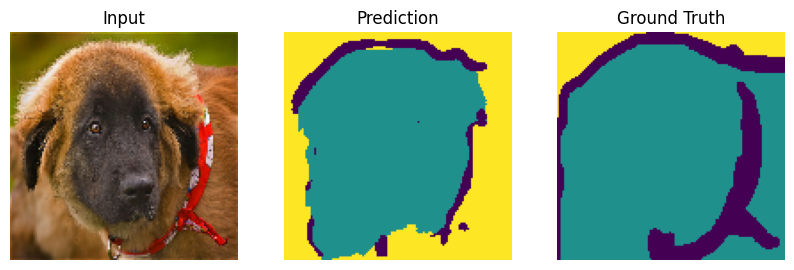

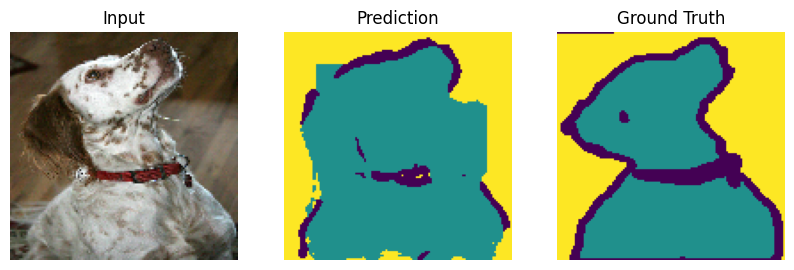

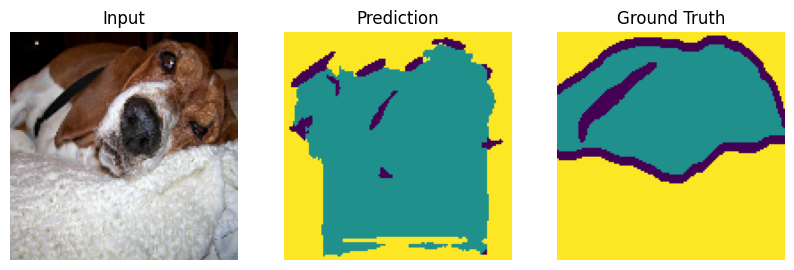

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
!pip install tensorflow
# %%
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 데이터 불러오기 및 전처리
# Load the dataset using the supported version 4.0.0
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)
def preprocess(x):
    image = tf.image.resize(x['image'], (128, 128))
    mask = tf.image.resize(x['segmentation_mask'], (128, 128), method='nearest')
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.uint8)
    # Remap mask values: 3 (border) to 0 (background)
    # The original mask values are 1 (pet), 2 (outline), 3 (border), and 0 (background).
    # We want our model to predict 3 classes: background (0), pet (1), outline (2).
    # The border value 3 is typically ignored or mapped to background.

    mask = tf.where(mask == 3, tf.zeros_like(mask), mask) # mask 텐서 내 값이 3인 위치를 0으로 바꾸고, 나머지는 그대로 두는 작업입니다.
    # Ensure mask values are in the range [0, 2]
    # It's good practice to assert this, though the remapping should handle it.

    tf.debugging.assert_less(mask, tf.constant(3, dtype=tf.uint8)) # mask의 모든 원소 값이 3 미만이어야 통과 (즉, 0,1,2 가능).
    tf.debugging.assert_greater_equal(mask, tf.constant(0, dtype=tf.uint8))
    return image, mask

train_ds = dataset['train'].map(preprocess).cache().shuffle(100).batch(8).prefetch(tf.data.AUTOTUNE)

# U-Net 모델 정의
def unet_model(input_size=(128, 128, 3), num_classes=3):
    inputs = tf.keras.Input(shape=input_size)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    b = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(b)

    u1 = layers.UpSampling2D()(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c4)
    return models.Model(inputs, outputs)

# 모델 컴파일 및 학습
model = unet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, epochs=3)

# 시각화
for images, masks in train_ds.take(1): # tf.data.Dataset에서 첫 번째 배치(batch)만 가져와서 images와 masks 변수에 할당하는 코드입니다.
    preds = model.predict(images)
    for i in range(3):
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1); plt.imshow(images[i]); plt.title("Input"); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(tf.argmax(preds[i], axis=-1)); plt.title("Prediction"); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(tf.squeeze(masks[i])); plt.title("Ground Truth"); plt.axis('off') # squeeze()는 텐서(배열)에서 크기가 1인 차원(dim)을 제거하는 함수입니다.
        plt.show()